In [1]:
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
%matplotlib inline

################################################################################
# Some simple plotting utilities
################################################################################


def plot_data(data: np.ndarray,
              labels: np.ndarray,
              ax: matplotlib.axes.Axes = None):
    """
    A helper function to plot our data sets

    PARAMETERS
    ----------
    data      A numpy array of 2 columns (dimensions) and 2*examples_per_class rows

    labels    A numpy vector with 2*examples_per_class, with a +1 or -1 in each
              element. The jth element is the label of the jth example

    ax        An optional matplotlib axis object to plot to
    """

    # require shape (n, 2)
    assert data.ndim == 2
    assert data.shape[-1] == 2

    if type(data) == torch.Tensor:
        data = data.numpy()

    # plot the data
    pos_idx = np.where(labels == 1)
    neg_idx = np.where(labels == -1)

    if ax is None:
        ax = plt
    ax.plot(
        data.T[0, pos_idx],
        data.T[1, pos_idx],
        'r^',
        label='positive'
    )
    ax.plot(
        data.T[0, neg_idx],
        data.T[1, neg_idx],
        'bo',
        label='negative'
    )
    ax.axis('equal')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right")

    if ax is None:
        plt.show()


def plot_decision_surface(model=None,
                          axis_limits=(-5, 5, -5, 5),
                          ax: matplotlib.axes.Axes = None
                          ):
    """
    Creates a grid of points, measures what a model would label each
    point as, and uses this data to draw a region for class +1 and a region for
    class -1.

    PARAMETERS
    ----------
    model       A callable model that can take 2-d real-valued input and produce
                a +1 or -1 label for each data point.

    axis_limits An array-like object with 4 floats [lowest_horizontal, highest_horizontal,
                lowest_vertical, highest_vertical]. This sets the limits over which
                the decision surface will be caluclated and plotted.

    ax          An optional matplotlib axis object to plot to

    RETURNS
    -------
    my_contour  a matplotlib.contour.QuadContourSet with the contour
    """

    # Create a grid of points spanning the entire space displayed in the axis.
    # This will let us draw the decision boundary later
    xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], .05),
                         np.arange(axis_limits[2], axis_limits[3], .05))
    data = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])]).T

    # Predict the class of each point in XGrid, using the classifier.
    # This shows our regions determined by the classifier
    if isinstance(model, nn.Module):
        with torch.no_grad():
            pl = model(torch.tensor(data).to(dtype=torch.float32))
            predicted_labels = np.sign(pl.numpy())
    else:
        predicted_labels = model(data)

    predicted_labels = predicted_labels.reshape(xx.shape)

    # Put the result into a color plot
    if ax is None:
        ax = plt

    ax.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired)
    ax.axis('equal')
    ax.axis('tight')

    if ax is None:
        plt.show()


def compute_bounds(features):
    min1, max1 = features[:, 0].min()-1, features[:, 0].max()+1
    min2, max2 = features[:, 1].min()-1, features[:, 1].max()+1
    return (min1, max1, min2, max2)


def plot_decision_regions(
        features, targets, model,
        axis=None, transform=None,
        bounds=None,
        title='Decision Surface'):
    """
    Slightly different plotting approach than above. Used in backprop demo.

    This function produces a single plot containing a scatter plot of the
    features, targets, and decision region of the model.

    Args:
        features (np.ndarray): 2D array containing real-valued inputs.
        targets (np.ndarray): 1D array containing binary targets.
        model: a learner with .predict() method
        axis: the axis on which to plot. If None, create a new plot
        title: title of the plot
    Returns:
        None (plots to the active figure)
    """

    # define bounds of the domain
    if bounds is None:
        min1, max1, min2, max2 = compute_bounds(features)
    else:
        min1, max1, min2, max2 = bounds

    # define grid for visualizing decision regions
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)

    xx, yy = np.meshgrid(x1grid, x2grid)

    # flatten grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # horizontally stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))

    # if we're transforming the features, do that now
    #     this allows xx and yy to still be in 2D for the visualization
    #     but grid has been transformed so it matches up with the fit model
    if transform is not None:
        grid = transform(grid)

    # generate predictions over grid
    yhat = model.predict(grid)

    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)


    if axis is None:
        fig, axis = plt.subplots()

    # plot the grid of x, y and z values as a surface
    binary_cmap = matplotlib.colors.ListedColormap(['#9ce8ff', '#ffc773'])
    axis.contourf(xx, yy, zz, cmap=binary_cmap, alpha=0.7)

    # plot "negative" class:
    row_idx_neg = np.where(targets < 0.5)[0]
    axis.scatter(
        features[row_idx_neg, 0], features[row_idx_neg, 1],
        label='negative')

    # plot "positive" class:
    row_idx_pos = np.where(targets > 0.5)[0]
    axis.scatter(
        features[row_idx_pos, 0], features[row_idx_pos, 1],
        label='positive')

    axis.set_title(title)
    axis.set_xlim(min1, max1)
    axis.set_ylim(min2, max2)

    axis.legend(loc="upper left")

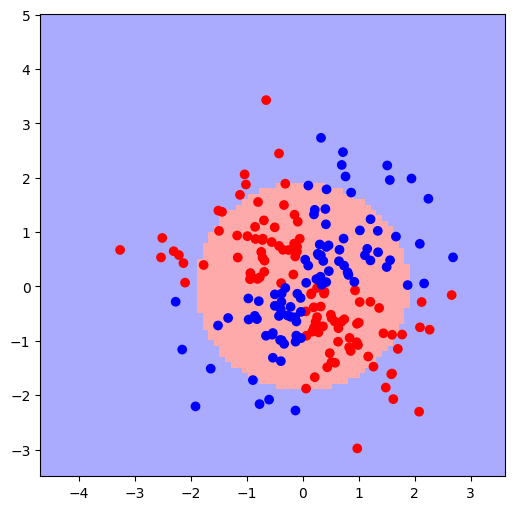

In [4]:
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import sys
import os
import random

%matplotlib inline

np.random.seed(42)
torch.manual_seed(0)

def read_data(name,mode):

    x_data = []
    y_data = []
    label_data = []

    base_dir = os.getcwd()
    root = base_dir
    filename = '%s/%s_%s.csv' % (root,name,mode)

    i = 0
    with open(filename,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(',')
            if i > 0:
                y = int(float(tokens[0]))
                x1 = float(tokens[1])
                x2 = float(tokens[2])
                x_data.append([1.0,x1,x2])
                y_data.append([y])
                temp = [0,0]
                temp[y] = 1
                label_data.append(temp)
            i = i + 1
    xs = np.array(x_data,dtype='float32')
    ys = np.array(y_data,dtype='float32')
    labels = np.array(label_data,dtype='float32')
    return(xs,ys,labels)

class net3(nn.Module):
    def __init__(self,input_size,nodes,output_size):
        super(net3,self).__init__()
#        self.l1 = nn.Linear(input_size,nodes)
#        self.activation = nn.Tanh()

    def forward(self,x):
#        output = self.l1(x)
#        output = self.activation(output)
        a = torch.mul(x[:,1],x[:,1])
        b = torch.mul(x[:,2],x[:,2])
        c = (a+b)/9.0
        output = torch.exp(c)
        return output

def draw_example(nodes,name,model):
    x_train, y_train, label_train = read_data(name,'train')
    x_test, y_test, label_test = read_data(name,'test')

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6*(1+0)))

    h = .1  # step size in the mesh
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    y_min, y_max = x_train[:, 2].min() - 1, x_train[:, 2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Z = np.zeros([xx.shape[0],yy.shape[1]],dtype='float32')
    Z2 = np.zeros([nodes,xx.shape[0],yy.shape[1]],dtype='float32')
    grid_data = np.ones([1,3],dtype='float32')

    grid_data2 = np.zeros([1,3],dtype='float32')
    for i in range(xx.shape[0]):
        for j in range(yy.shape[1]):
            x = xx[i,j]
            y = yy[i,j]
            grid_data2[0,0] = 1.0
            grid_data2[0,1] = x
            grid_data2[0,2] = y

            x = torch.from_numpy(grid_data2)
            pred = model(x)
            if (pred[0].item()-6.0) > -4.5:
                yh = 1.0
            else:
                yh = 0.0
            Z[i,j] = yh
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
    ax.scatter(x_test[:, 1], x_test[:, 2], c=y_test[:,0], cmap=cmap_bold)

nodes = 3
name = 'xor'
model = net3(3,nodes,1)
draw_example(nodes,name,model=model)

